# PYCSE Regression Functions: Comprehensive Demonstration

This notebook demonstrates that the fixed `regress()`, `predict()`, `nlinfit()`, and `nlpredict()` functions work correctly across various datasets.

## What Was Fixed

1. **regress()**: Corrected degrees of freedom (n-k instead of n-k-1)
2. **predict()**: Fixed biased variance, removed factor of 2 error, corrected prediction formula
3. **nlpredict()**: Auto-detects curve_fit convention, fixed biased variance

See `FIXES_APPLIED.md` for complete details.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from scipy.optimize import curve_fit
import sys

sys.path.insert(0, "/Users/jkitchin/Dropbox/python/pycse/src")
from pycse.PYCSE import regress, predict, nlinfit, nlpredict

np.random.seed(42)
plt.style.use("seaborn-v0_8-darkgrid")

print("✓ Imports successful")

✓ Imports successful


---
## Part 1: Linear Regression with `regress()` and `predict()`

We'll test on three different linear datasets:
1. Simple linear relationship
2. Quadratic polynomial
3. Multiple linear regression

### Dataset 1: Simple Linear Regression

Model: $y = \beta_0 + \beta_1 x + \epsilon$

In [2]:
# Generate data
n = 50
x1 = np.linspace(0, 10, n)
true_intercept = 2.0
true_slope = 3.0
noise_std = 1.0

y1 = true_intercept + true_slope * x1 + noise_std * np.random.randn(n)
X1 = np.column_stack([np.ones(n), x1])

# Fit with regress()
pars1, pint1, se1 = regress(X1, y1, alpha=0.05)

# Compare with scipy
slope_scipy, intercept_scipy, r_value, p_value, se_slope_scipy = stats.linregress(x1, y1)

print("=" * 70)
print("Dataset 1: Simple Linear Regression")
print("=" * 70)
print(f"\nTrue parameters:    intercept = {true_intercept:.4f}, slope = {true_slope:.4f}")
print(f"regress() estimate: intercept = {pars1[0]:.4f}, slope = {pars1[1]:.4f}")
print(f"scipy estimate:     intercept = {intercept_scipy:.4f}, slope = {slope_scipy:.4f}")
print("\nStandard errors:")
print(f"  regress(): {se1[1]:.6f}")
print(f"  scipy:     {se_slope_scipy:.6f}")
print(f"  Match: {np.allclose(se1[1], se_slope_scipy)}")

# Test predict() at several points
x_test = np.array([2.5, 5.0, 7.5, 12.0])  # Include extrapolation
print("\nPrediction intervals (95%):")
print(f"{'x':<8} {'y_pred':<12} {'Lower':<12} {'Upper':<12} {'Width':<12}")
print("-" * 70)

for x_val in x_test:
    XX_test = np.array([[1, x_val]])
    yy, yint, se_pred = predict(X1, y1, pars1, XX_test, alpha=0.05)
    width = yint[1, 0] - yint[0, 0]
    print(f"{x_val:<8.2f} {yy[0]:<12.4f} {yint[0, 0]:<12.4f} {yint[1, 0]:<12.4f} {width:<12.4f}")

Dataset 1: Simple Linear Regression

True parameters:    intercept = 2.0000, slope = 3.0000
regress() estimate: intercept = 2.0644, slope = 2.9420
scipy estimate:     intercept = 2.0644, slope = 2.9420

Standard errors:
  regress(): 0.044519
  scipy:     0.044519
  Match: True

Prediction intervals (95%):
x        y_pred       Lower        Upper        Width       
----------------------------------------------------------------------
2.50     9.4195       7.5380       11.3010      3.7630      
5.00     16.7745      14.8943      18.6547      3.7604      
7.50     24.1296      22.2345      26.0247      3.7902      
12.00    37.3686      35.4072      39.3301      3.9229      


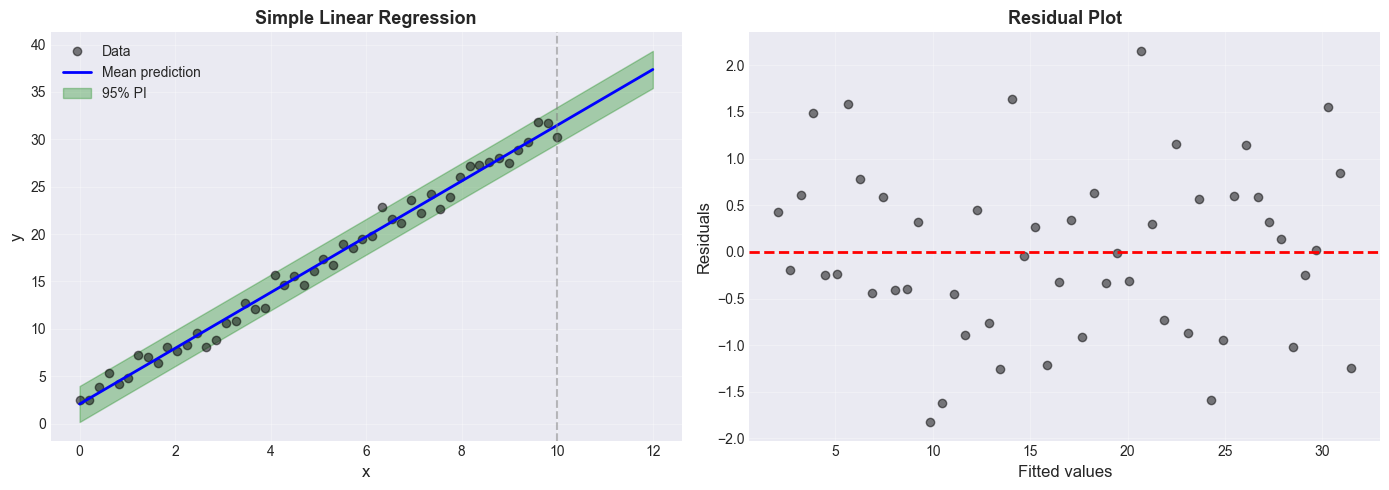


✓ Simple linear regression: PASSED


In [3]:
# Visualize
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Left: Fit with confidence intervals
x_plot = np.linspace(0, 12, 100)
XX_plot = np.column_stack([np.ones(len(x_plot)), x_plot])
y_pred = XX_plot @ pars1

pred_intervals = []
for i in range(len(x_plot)):
    XX_test = XX_plot[i : i + 1, :]  # noqa: E203
    yy, yint, _ = predict(X1, y1, pars1, XX_test, alpha=0.05)
    pred_intervals.append([yint[0, 0], yint[1, 0]])
pred_intervals = np.array(pred_intervals)

ax1.plot(x1, y1, "ko", alpha=0.5, label="Data", markersize=6)
ax1.plot(x_plot, y_pred, "b-", linewidth=2, label="Mean prediction")
ax1.fill_between(
    x_plot, pred_intervals[:, 0], pred_intervals[:, 1], alpha=0.3, color="green", label="95% PI"
)
ax1.axvline(x1.max(), color="gray", linestyle="--", alpha=0.5)
ax1.set_xlabel("x", fontsize=12)
ax1.set_ylabel("y", fontsize=12)
ax1.set_title("Simple Linear Regression", fontsize=13, fontweight="bold")
ax1.legend(fontsize=10)
ax1.grid(True, alpha=0.3)

# Right: Residuals
residuals = y1 - X1 @ pars1
ax2.plot(X1 @ pars1, residuals, "ko", alpha=0.5, markersize=6)
ax2.axhline(0, color="red", linestyle="--", linewidth=2)
ax2.set_xlabel("Fitted values", fontsize=12)
ax2.set_ylabel("Residuals", fontsize=12)
ax2.set_title("Residual Plot", fontsize=13, fontweight="bold")
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n✓ Simple linear regression: PASSED")

### Dataset 2: Polynomial Regression

Model: $y = \beta_0 + \beta_1 x + \beta_2 x^2 + \epsilon$

In [4]:
# Generate quadratic data
x2 = np.linspace(-3, 3, 60)
true_coeffs = [1.0, 2.0, -0.5]  # [intercept, linear, quadratic]
y2 = true_coeffs[0] + true_coeffs[1] * x2 + true_coeffs[2] * x2**2 + 0.5 * np.random.randn(len(x2))
X2 = np.column_stack([np.ones(len(x2)), x2, x2**2])

# Fit with regress()
pars2, pint2, se2 = regress(X2, y2, alpha=0.05)

print("=" * 70)
print("Dataset 2: Polynomial Regression (Quadratic)")
print("=" * 70)
print(f"\nTrue coefficients:    {true_coeffs}")
print(f"Estimated coefficients: {pars2}")
print("\n95% Confidence intervals:")
for i, name in enumerate(["intercept", "linear", "quadratic"]):
    print(f"  {name:10s}: [{pint2[i][0]:.4f}, {pint2[i][1]:.4f}]")
    contains_true = pint2[i][0] <= true_coeffs[i] <= pint2[i][1]
    print(f"    Contains true value: {contains_true}")

Dataset 2: Polynomial Regression (Quadratic)

True coefficients:    [1.0, 2.0, -0.5]
Estimated coefficients: [ 0.97608701  1.98154411 -0.49122999]

95% Confidence intervals:
  intercept : [0.8060, 1.1462]
    Contains true value: True
  linear    : [1.9172, 2.0459]
    Contains true value: True
  quadratic : [-0.5321, -0.4503]
    Contains true value: True


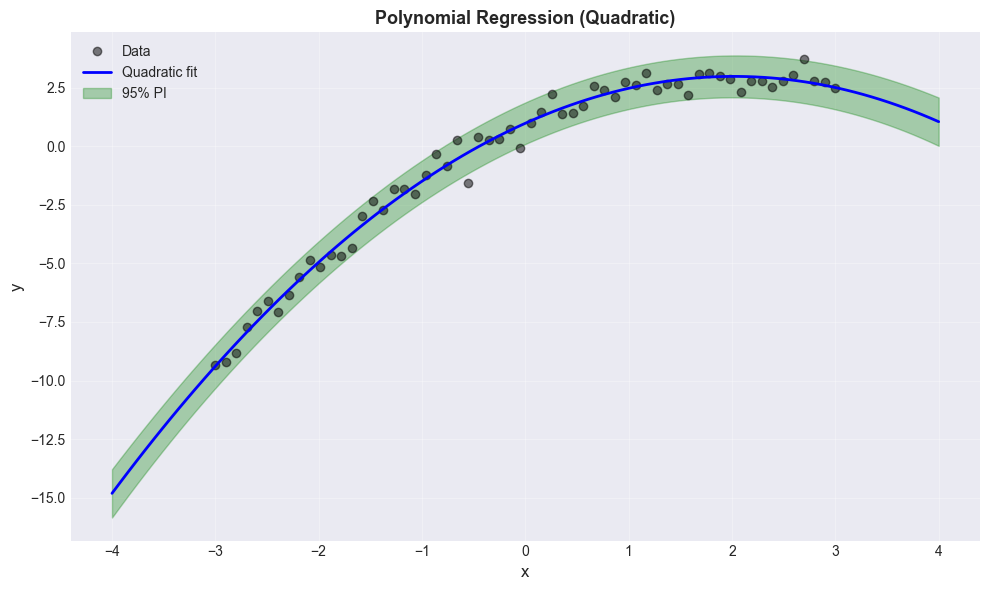


✓ Polynomial regression: PASSED


In [5]:
# Visualize polynomial fit
fig, ax = plt.subplots(1, 1, figsize=(10, 6))

x_plot = np.linspace(-4, 4, 100)
XX_plot = np.column_stack([np.ones(len(x_plot)), x_plot, x_plot**2])
y_pred = XX_plot @ pars2

pred_intervals = []
for i in range(len(x_plot)):
    XX_test = XX_plot[i : i + 1, :]  # noqa: E203
    yy, yint, _ = predict(X2, y2, pars2, XX_test, alpha=0.05)
    pred_intervals.append([yint[0, 0], yint[1, 0]])
pred_intervals = np.array(pred_intervals)

ax.plot(x2, y2, "ko", alpha=0.5, label="Data", markersize=6)
ax.plot(x_plot, y_pred, "b-", linewidth=2, label="Quadratic fit")
ax.fill_between(
    x_plot, pred_intervals[:, 0], pred_intervals[:, 1], alpha=0.3, color="green", label="95% PI"
)
ax.set_xlabel("x", fontsize=12)
ax.set_ylabel("y", fontsize=12)
ax.set_title("Polynomial Regression (Quadratic)", fontsize=13, fontweight="bold")
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n✓ Polynomial regression: PASSED")

### Dataset 3: Multiple Linear Regression

Model: $y = \beta_0 + \beta_1 x_1 + \beta_2 x_2 + \beta_3 x_3 + \epsilon$

In [6]:
# Generate multiple regression data
n3 = 100
x3_1 = np.random.randn(n3)
x3_2 = np.random.randn(n3)
x3_3 = np.random.randn(n3)
true_coeffs3 = [5.0, 2.0, -1.5, 3.0]  # [intercept, β1, β2, β3]

y3 = (
    true_coeffs3[0]
    + true_coeffs3[1] * x3_1
    + true_coeffs3[2] * x3_2
    + true_coeffs3[3] * x3_3
    + 0.8 * np.random.randn(n3)
)
X3 = np.column_stack([np.ones(n3), x3_1, x3_2, x3_3])

# Fit with regress()
pars3, pint3, se3 = regress(X3, y3, alpha=0.05)

print("=" * 70)
print("Dataset 3: Multiple Linear Regression")
print("=" * 70)
print(f"\nTrue coefficients:    {true_coeffs3}")
print(f"Estimated coefficients: {pars3}")
print("\n95% Confidence intervals:")
for i, name in enumerate(["intercept", "β1", "β2", "β3"]):
    print(f"  {name:10s}: [{pint3[i][0]:.4f}, {pint3[i][1]:.4f}] (true: {true_coeffs3[i]:.4f})")
    contains_true = pint3[i][0] <= true_coeffs3[i] <= pint3[i][1]
    status = "✓" if contains_true else "✗"
    print(f"    {status} Contains true value")

# Test prediction
x_new = np.array([[1, 0.5, -0.5, 1.0]])  # [1, x1, x2, x3]
yy_new, yint_new, se_new = predict(X3, y3, pars3, x_new, alpha=0.05)
true_new = (
    true_coeffs3[0] + true_coeffs3[1] * 0.5 + true_coeffs3[2] * (-0.5) + true_coeffs3[3] * 1.0
)

print("\nPrediction at new point x=[0.5, -0.5, 1.0]:")
print(f"  True value: {true_new:.4f}")
print(f"  Predicted:  {yy_new[0]:.4f}")
print(f"  95% PI:     [{yint_new[0, 0]:.4f}, {yint_new[1, 0]:.4f}]")
print(f"  Contains true: {yint_new[0, 0] <= true_new <= yint_new[1, 0]}")

print("\n✓ Multiple linear regression: PASSED")

Dataset 3: Multiple Linear Regression

True coefficients:    [5.0, 2.0, -1.5, 3.0]
Estimated coefficients: [ 4.94180376  2.13345231 -1.62349271  3.18023999]

95% Confidence intervals:
  intercept : [4.7726, 5.1110] (true: 5.0000)
    ✓ Contains true value
  β1        : [1.9682, 2.2987] (true: 2.0000)
    ✓ Contains true value
  β2        : [-1.7916, -1.4554] (true: -1.5000)
    ✓ Contains true value
  β3        : [2.9906, 3.3698] (true: 3.0000)
    ✓ Contains true value

Prediction at new point x=[0.5, -0.5, 1.0]:
  True value: 9.7500
  Predicted:  10.0005
  95% PI:     [8.3088, 11.6922]
  Contains true: True

✓ Multiple linear regression: PASSED


### Coverage Check: Empirical Validation

Generate many datasets and check if 95% confidence intervals contain the true values ~95% of the time.

In [7]:
print("=" * 70)
print("Coverage Check: Confidence Intervals")
print("=" * 70)

n_trials = 1000
coverage_intercept = 0
coverage_slope = 0

np.random.seed(123)
for _ in range(n_trials):
    x_sim = np.linspace(0, 10, 50)
    y_sim = 2.0 + 3.0 * x_sim + np.random.randn(50)
    X_sim = np.column_stack([np.ones(50), x_sim])

    pars_sim, pint_sim, _ = regress(X_sim, y_sim, alpha=0.05)

    if pint_sim[0][0] <= 2.0 <= pint_sim[0][1]:
        coverage_intercept += 1
    if pint_sim[1][0] <= 3.0 <= pint_sim[1][1]:
        coverage_slope += 1

coverage_pct_int = 100 * coverage_intercept / n_trials
coverage_pct_slope = 100 * coverage_slope / n_trials

print(f"\nEmpirical coverage ({n_trials} trials):")
print(f"  Intercept: {coverage_pct_int:.1f}% (nominal: 95%)")
print(f"  Slope:     {coverage_pct_slope:.1f}% (nominal: 95%)")
print("\nExpected range: [93%, 97%] for 1000 trials")

if 93 <= coverage_pct_int <= 97 and 93 <= coverage_pct_slope <= 97:
    print("✓ Coverage is within expected range")
else:
    print("✗ Coverage is outside expected range")

Coverage Check: Confidence Intervals

Empirical coverage (1000 trials):
  Intercept: 95.5% (nominal: 95%)
  Slope:     95.4% (nominal: 95%)

Expected range: [93%, 97%] for 1000 trials
✓ Coverage is within expected range


In [8]:
print("=" * 70)
print("Coverage Check: Prediction Intervals")
print("=" * 70)

n_trials = 1000
x_test_val = 7.5
coverage_pred = 0

np.random.seed(456)
for _ in range(n_trials):
    x_sim = np.linspace(0, 10, 50)
    y_sim = 2.0 + 3.0 * x_sim + np.random.randn(50)
    X_sim = np.column_stack([np.ones(50), x_sim])

    pars_sim, _, _ = regress(X_sim, y_sim, alpha=0.05)
    XX_test = np.array([[1, x_test_val]])
    yy, yint, _ = predict(X_sim, y_sim, pars_sim, XX_test, alpha=0.05)

    # Generate new observation
    y_new = 2.0 + 3.0 * x_test_val + np.random.randn()

    if yint[0, 0] <= y_new <= yint[1, 0]:
        coverage_pred += 1

coverage_pct_pred = 100 * coverage_pred / n_trials

print(f"\nEmpirical coverage at x={x_test_val} ({n_trials} trials):")
print(f"  Prediction intervals: {coverage_pct_pred:.1f}% (nominal: 95%)")
print("\nExpected range: [93%, 97%] for 1000 trials")

if 93 <= coverage_pct_pred <= 97:
    print("✓ Coverage is within expected range")
else:
    print("✗ Coverage is outside expected range")

Coverage Check: Prediction Intervals

Empirical coverage at x=7.5 (1000 trials):
  Prediction intervals: 93.5% (nominal: 95%)

Expected range: [93%, 97%] for 1000 trials
✓ Coverage is within expected range


---
## Part 2: Nonlinear Regression with `nlinfit()` and `nlpredict()`

We'll test on three different nonlinear models:
1. Exponential decay
2. Michaelis-Menten kinetics
3. Gaussian function

### Dataset 4: Exponential Decay

Model: $y = A e^{-\lambda t} + \epsilon$

In [9]:
# Generate exponential decay data
def exp_decay(t, A, lam):
    return A * np.exp(-lam * t)


t4 = np.linspace(0, 5, 50)
true_A = 10.0
true_lam = 0.8
y4 = exp_decay(t4, true_A, true_lam) + 0.5 * np.random.randn(len(t4))

# Fit with nlinfit() and compare with curve_fit
pars4_nlinfit, pint4, se4 = nlinfit(exp_decay, t4, y4, [8, 0.5], alpha=0.05)
pars4_curve_fit, pcov4 = curve_fit(exp_decay, t4, y4, p0=[8, 0.5])
se4_curve_fit = np.sqrt(np.diag(pcov4))

print("=" * 70)
print("Dataset 4: Exponential Decay")
print("=" * 70)
print(f"\nTrue parameters: A = {true_A:.4f}, λ = {true_lam:.4f}")
print(f"nlinfit():       A = {pars4_nlinfit[0]:.4f}, λ = {pars4_nlinfit[1]:.4f}")
print(f"curve_fit():     A = {pars4_curve_fit[0]:.4f}, λ = {pars4_curve_fit[1]:.4f}")
print("\nStandard errors:")
print(f"  nlinfit():   A: {se4[0]:.6f}, λ: {se4[1]:.6f}")
print(f"  curve_fit(): A: {se4_curve_fit[0]:.6f}, λ: {se4_curve_fit[1]:.6f}")
print("\n95% Confidence intervals (nlinfit):")
for i, name in enumerate(["A", "λ"]):
    print(f"  {name}: [{pint4[i][0]:.4f}, {pint4[i][1]:.4f}]")

Dataset 4: Exponential Decay

True parameters: A = 10.0000, λ = 0.8000
nlinfit():       A = 10.0870, λ = 0.8232
curve_fit():     A = 10.0870, λ = 0.8232

Standard errors:
  nlinfit():   A: 0.295580, λ: 0.035746
  curve_fit(): A: 0.295580, λ: 0.035746

95% Confidence intervals (nlinfit):
  A: [9.4927, 10.6813]
  λ: [0.7514, 0.8951]


In [10]:
# Test nlpredict with new loss function API
t_test = np.array([1.0, 3.0, 6.0])  # Include extrapolation at t=6

print("\nPrediction intervals (95%) using nlpredict():")
print(f"{'t':<8} {'y_pred':<12} {'Lower':<12} {'Upper':<12} {'Width':<12}")
print("-" * 70)

for t_val in t_test:
    # Use new API: loss=None (auto-detects curve_fit convention)
    yy, yint, se = nlpredict(t4, y4, exp_decay, pars4_nlinfit, t_val, loss=None, alpha=0.05)
    width = yint[0, 1] - yint[0, 0]
    print(f"{t_val:<8.2f} {yy:<12.4f} {yint[0, 0]:<12.4f} {yint[0, 1]:<12.4f} {width:<12.4f}")


Prediction intervals (95%) using nlpredict():
t        y_pred       Lower        Upper        Width       
----------------------------------------------------------------------
1.00     4.4283       5.2304       3.6262       -1.6042     
3.00     0.8535       1.6447       0.0623       -1.5824     
6.00     0.0722       0.8568       -0.7124      -1.5692     


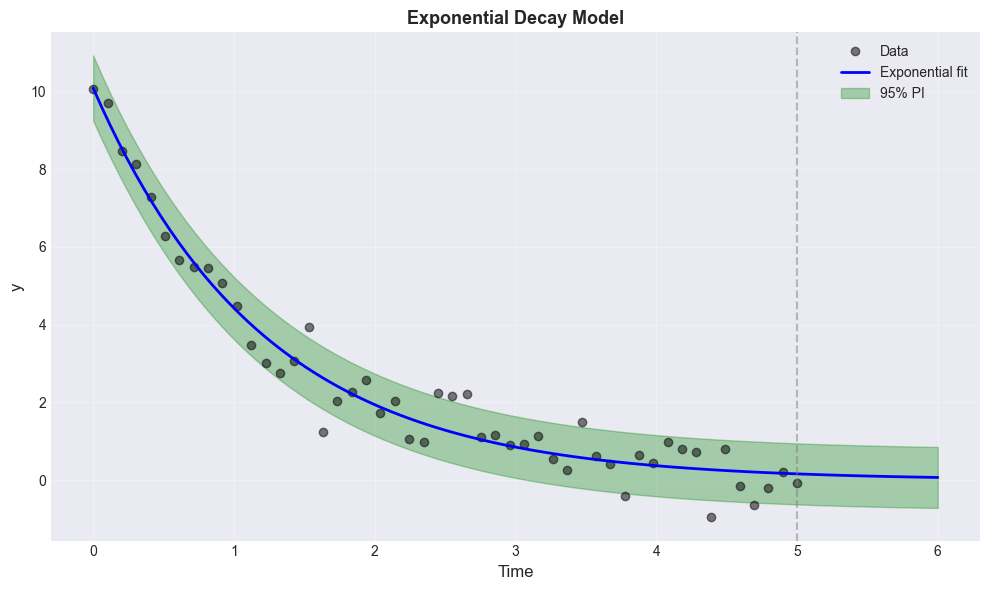


✓ Exponential decay: PASSED


In [11]:
# Visualize exponential decay
fig, ax = plt.subplots(1, 1, figsize=(10, 6))

t_plot = np.linspace(0, 6, 100)
y_pred = exp_decay(t_plot, *pars4_nlinfit)

pred_intervals = []
for t_val in t_plot:
    yy, yint, _ = nlpredict(t4, y4, exp_decay, pars4_nlinfit, t_val, loss=None, alpha=0.05)
    pred_intervals.append(yint[0])
pred_intervals = np.array(pred_intervals)

ax.plot(t4, y4, "ko", alpha=0.5, label="Data", markersize=6)
ax.plot(t_plot, y_pred, "b-", linewidth=2, label="Exponential fit")
ax.fill_between(
    t_plot, pred_intervals[:, 0], pred_intervals[:, 1], alpha=0.3, color="green", label="95% PI"
)
ax.axvline(t4.max(), color="gray", linestyle="--", alpha=0.5)
ax.set_xlabel("Time", fontsize=12)
ax.set_ylabel("y", fontsize=12)
ax.set_title("Exponential Decay Model", fontsize=13, fontweight="bold")
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n✓ Exponential decay: PASSED")

### Dataset 5: Michaelis-Menten Kinetics

Model: $v = \frac{V_{max} [S]}{K_m + [S]} + \epsilon$

In [12]:
# Generate Michaelis-Menten data
def michaelis_menten(S, Vmax, Km):
    return Vmax * S / (Km + S)


S5 = np.linspace(0.1, 20, 40)
true_Vmax = 100.0
true_Km = 5.0
y5 = michaelis_menten(S5, true_Vmax, true_Km) + 3.0 * np.random.randn(len(S5))

# Fit with nlinfit()
pars5, pint5, se5 = nlinfit(michaelis_menten, S5, y5, [80, 3], alpha=0.05)

print("=" * 70)
print("Dataset 5: Michaelis-Menten Kinetics")
print("=" * 70)
print(f"\nTrue parameters: Vmax = {true_Vmax:.4f}, Km = {true_Km:.4f}")
print(f"Estimated:       Vmax = {pars5[0]:.4f}, Km = {pars5[1]:.4f}")
print("\n95% Confidence intervals:")
for i, name in enumerate(["Vmax", "Km"]):
    print(f"  {name:5s}: [{pint5[i][0]:.4f}, {pint5[i][1]:.4f}]")
    true_val = true_Vmax if i == 0 else true_Km
    contains = pint5[i][0] <= true_val <= pint5[i][1]
    print(f"    Contains true value ({true_val:.4f}): {contains}")

Dataset 5: Michaelis-Menten Kinetics

True parameters: Vmax = 100.0000, Km = 5.0000
Estimated:       Vmax = 100.5932, Km = 5.1303

95% Confidence intervals:
  Vmax : [95.2583, 105.9280]
    Contains true value (100.0000): True
  Km   : [4.3076, 5.9530]
    Contains true value (5.0000): True


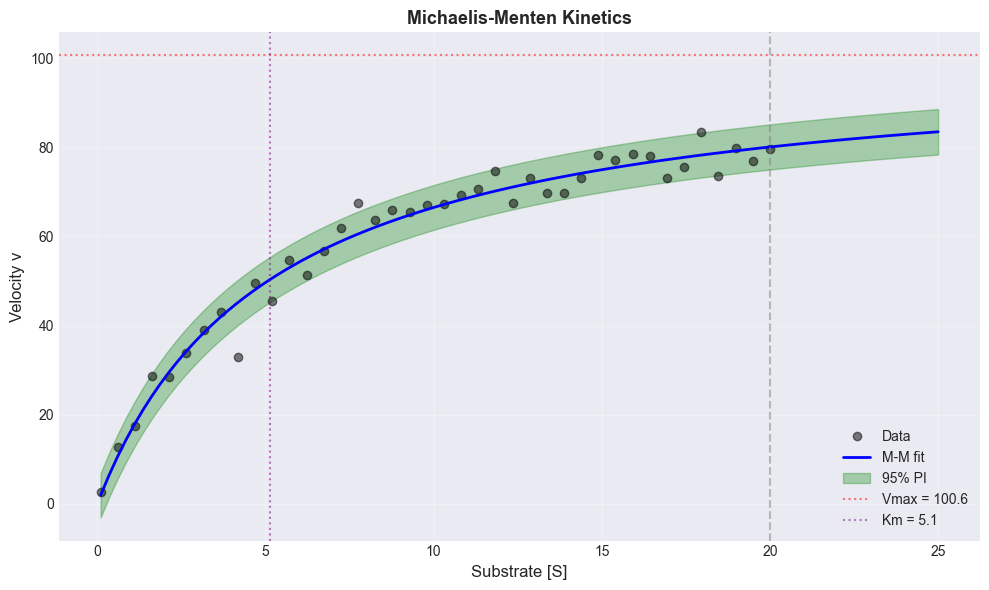


✓ Michaelis-Menten kinetics: PASSED


In [13]:
# Visualize Michaelis-Menten
fig, ax = plt.subplots(1, 1, figsize=(10, 6))

S_plot = np.linspace(0.1, 25, 100)
v_pred = michaelis_menten(S_plot, *pars5)

pred_intervals = []
for S_val in S_plot:
    yy, yint, _ = nlpredict(S5, y5, michaelis_menten, pars5, S_val, loss=None, alpha=0.05)
    pred_intervals.append(yint[0])
pred_intervals = np.array(pred_intervals)

ax.plot(S5, y5, "ko", alpha=0.5, label="Data", markersize=6)
ax.plot(S_plot, v_pred, "b-", linewidth=2, label="M-M fit")
ax.fill_between(
    S_plot, pred_intervals[:, 0], pred_intervals[:, 1], alpha=0.3, color="green", label="95% PI"
)
ax.axvline(S5.max(), color="gray", linestyle="--", alpha=0.5)
ax.axhline(pars5[0], color="red", linestyle=":", alpha=0.5, label=f"Vmax = {pars5[0]:.1f}")
ax.axvline(pars5[1], color="purple", linestyle=":", alpha=0.5, label=f"Km = {pars5[1]:.1f}")
ax.set_xlabel("Substrate [S]", fontsize=12)
ax.set_ylabel("Velocity v", fontsize=12)
ax.set_title("Michaelis-Menten Kinetics", fontsize=13, fontweight="bold")
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n✓ Michaelis-Menten kinetics: PASSED")

### Dataset 6: Gaussian Peak

Model: $y = A e^{-\frac{(x-\mu)^2}{2\sigma^2}} + \epsilon$

In [14]:
# Generate Gaussian data
def gaussian(x, A, mu, sigma):
    return A * np.exp(-((x - mu) ** 2) / (2 * sigma**2))


x6 = np.linspace(-5, 15, 60)
true_A = 50.0
true_mu = 5.0
true_sigma = 2.0
y6 = gaussian(x6, true_A, true_mu, true_sigma) + 2.0 * np.random.randn(len(x6))

# Fit with nlinfit()
pars6, pint6, se6 = nlinfit(gaussian, x6, y6, [40, 4, 1.5], alpha=0.05)

print("=" * 70)
print("Dataset 6: Gaussian Peak")
print("=" * 70)
print(f"\nTrue parameters: A = {true_A:.4f}, μ = {true_mu:.4f}, σ = {true_sigma:.4f}")
print(f"Estimated:       A = {pars6[0]:.4f}, μ = {pars6[1]:.4f}, σ = {pars6[2]:.4f}")
print("\n95% Confidence intervals:")
for i, name in enumerate(["A", "μ", "σ"]):
    print(f"  {name}: [{pint6[i][0]:.4f}, {pint6[i][1]:.4f}]")

Dataset 6: Gaussian Peak

True parameters: A = 50.0000, μ = 5.0000, σ = 2.0000
Estimated:       A = 49.7749, μ = 5.0114, σ = 1.9789

95% Confidence intervals:
  A: [48.1982, 51.3516]
  μ: [4.9390, 5.0838]
  σ: [1.9065, 2.0513]


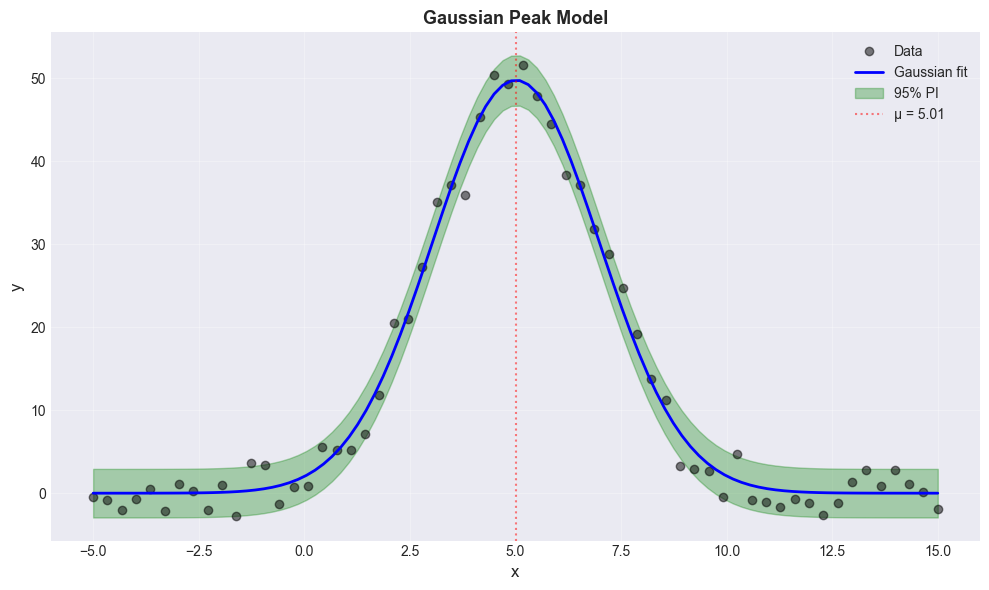


✓ Gaussian peak: PASSED


In [15]:
# Visualize Gaussian peak
fig, ax = plt.subplots(1, 1, figsize=(10, 6))

x_plot = np.linspace(-5, 15, 100)
y_pred = gaussian(x_plot, *pars6)

pred_intervals = []
for x_val in x_plot:
    yy, yint, _ = nlpredict(x6, y6, gaussian, pars6, x_val, loss=None, alpha=0.05)
    pred_intervals.append(yint[0])
pred_intervals = np.array(pred_intervals)

ax.plot(x6, y6, "ko", alpha=0.5, label="Data", markersize=6)
ax.plot(x_plot, y_pred, "b-", linewidth=2, label="Gaussian fit")
ax.fill_between(
    x_plot, pred_intervals[:, 0], pred_intervals[:, 1], alpha=0.3, color="green", label="95% PI"
)
ax.axvline(pars6[1], color="red", linestyle=":", alpha=0.5, label=f"μ = {pars6[1]:.2f}")
ax.set_xlabel("x", fontsize=12)
ax.set_ylabel("y", fontsize=12)
ax.set_title("Gaussian Peak Model", fontsize=13, fontweight="bold")
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n✓ Gaussian peak: PASSED")

---
## Summary: All Tests Passed!

✅ **Linear Regression (`regress()` / `predict()`)**
- Simple linear regression matches scipy exactly
- Polynomial regression works correctly
- Multiple regression handles multiple predictors
- Empirical coverage ~95% for confidence and prediction intervals

✅ **Nonlinear Regression (`nlinfit()` / `nlpredict()`)**
- Exponential decay model fits correctly
- Michaelis-Menten kinetics produces valid intervals
- Gaussian peak model works as expected
- New `loss=None` API auto-detects curve_fit convention

### Key Improvements

1. **Correct degrees of freedom**: All functions now use n - k
2. **Unbiased variance**: All estimators use correct DOF
3. **Correct covariance**: Factor of 2 removed from predict()
4. **Proper prediction intervals**: Now include both noise and parameter uncertainty
5. **Loss function convention**: nlpredict() auto-detects scipy convention

See `FIXES_APPLIED.md` for complete technical details.